# Forecasting with sktime - appendix: forecasting, supervised regression, and pitfalls in confusing the two

This notebook provides some supplementary explanation about the relation between forecasting as implemented in `sktime`, and the very common supervised prediction tasks as supported by `scikit-learn` and similar toolboxes.

Key points discussed in this notebook:

* Forecasting is not the same as supervised prediction;
* Even though forecasting can be "solved" by algorithms for supervised prediction, this is indirect and requires careful composition;
* From an interface perspective, this is correctly formulated as "reduction", i.e., use of a supervised predictor as a component within a forecaster;
* There are a number of pitfalls if this is manually done - such as, over-optimistic performance evaluation, information leakage, or "predicting the past" type errors.

In [1]:
# general imports
import numpy as np
import pandas as pd

## The pitfalls of mis-diagnosing forecasting as supervised regression

A common mistake is to mis-identify a forecasting problem as supervised regression - after all, in both we predict numbers, so surely this must be the same thing?

Indeed we predict numbers in both, but the set-up is different:

* In supervised regression, we predict *label/target variables* from *feature variables*, in a cross-sectional set-up. This is after training on label/feature examples.
* In forecasting, we predict *future values* from *past values*, of *the same variable*, in a temporal/sequential set-up. This is after training on the past.

In the common data frame representation:

* In supervised regression, we predict entries in a column from other columns. For this, we mainly make use of the statistical relation between those columns, learnt from examples of complete rows. The rows are all assumed exchangeable.
* In forecasting, we predict new rows, assuming temporal ordering in the rows. For this, we mainly make use of the statistical relation between previous and subsequent rows, learnt from the example of the observed sequence of rows. The rows are not exchangeable, but in temporal sequence.

### Pitfall 1: over-optimism in performance evaluation, false confidence in "broken" forecasters

Confusing the two tasks may lead to information leakage, and over-optimistic performance evaluation. This is because in supervised regression the ordering of rows does not matter, and train/test split is usually performed uniformly. In forecasting, the ordering does matter, both in training and in evaluation.

As subtle as it seems, this may have major practical consequences - since it can lead to the mistaken belief that a "broken" method is performant, which can cause damage to health, property, and other assets in real-life deployment.

The example below shows "problematic" performance estimation, when mistakenly using the regression evaluation workflow for forecasting.

In [2]:
from sklearn.model_selection import train_test_split

from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series

In [3]:
y = load_airline()

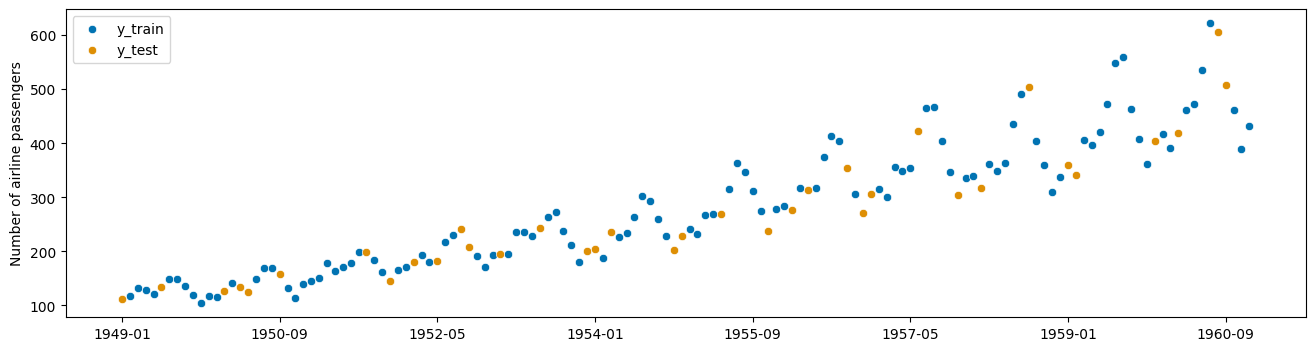

In [4]:
y_train, y_test = train_test_split(y)
plot_series(y_train.sort_index(), y_test.sort_index(), labels=["y_train", "y_test"]);

This leads to leakage:

> The data you are using to train a machine learning algorithm happens to have the information you are trying to predict.

But `train_test_split(y, shuffle=False)` works, which is what `temporal_train_test_split(y)` does in `sktime`:

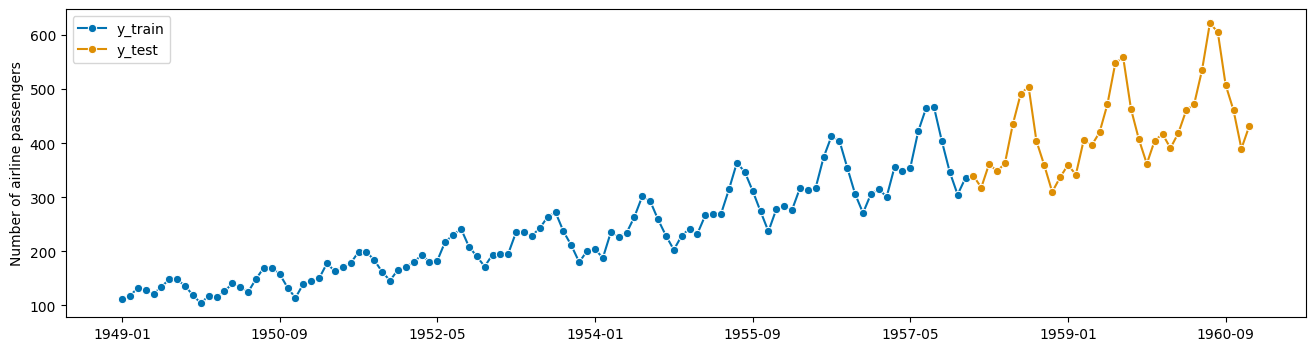

In [5]:
y_train, y_test = temporal_train_test_split(y)
plot_series(y_train, y_test, labels=["y_train", "y_test"]);

### Pitfall 2: obscure data manipulations, brittle boilerplate code to apply regressors

It is common practice to apply supervised regressors after transforming the data for forecasting, through lagging - for example, in auto-regressive reduction strategies.

Two important pitfalls appear right at the start:

* a lot of boilerplate code has to be written to transform the data to make it ready for fitting - this is highly error prone
* there are a number of implicit hyper-parameters here, such as window and lag size. If done without caution, these are not explicit or tracked in the experiment, which can lead to "p-value hacking".

Below is an example of such boilerplate code to demonstrate this. The code is closely modelled on the R code used in the [M4 competition](https://github.com/Mcompetitions/M4-methods):

In [6]:
# suppose we want to predict 3 years ahead
fh = np.arange(1, 37)

In [7]:
# slightly modified code from the M4 competition
def split_into_train_test(data, in_num, fh):
    """
    Splits the series into train and test sets.

    Each step takes multiple points as inputs
    :param data: an individual TS
    :param fh: number of out of sample points
    :param in_num: number of input points for the forecast
    :return:
    """
    train, test = data[:-fh], data[-(fh + in_num) :]
    x_train, y_train = train[:-1], np.roll(train, -in_num)[:-in_num]
    x_test, y_test = test[:-1], np.roll(test, -in_num)[:-in_num]
    #     x_test, y_test = train[-in_num:], np.roll(test, -in_num)[:-in_num]

    # reshape input to be [samples, time steps, features]
    # (N-NF samples, 1 time step, 1 feature)
    x_train = np.reshape(x_train, (-1, 1))
    x_test = np.reshape(x_test, (-1, 1))
    temp_test = np.roll(x_test, -1)
    temp_train = np.roll(x_train, -1)
    for _ in range(1, in_num):
        x_train = np.concatenate((x_train[:-1], temp_train[:-1]), 1)
        x_test = np.concatenate((x_test[:-1], temp_test[:-1]), 1)
        temp_test = np.roll(temp_test, -1)[:-1]
        temp_train = np.roll(temp_train, -1)[:-1]

    return x_train, y_train, x_test, y_test

In [8]:
# here we split the time index, rather than the actual values,
# to show how we split the windows
feature_window, target_window, _, _ = split_into_train_test(
    np.arange(len(y)), 10, len(fh)
)

To better understand the prior data transformation, we can look at how we can split the training series into windows. Here we show the generated windows expressed as integer indices:

In [9]:
feature_window[:5, :]

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
       [ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
       [ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13]])

In [10]:
target_window[:5]

array([10, 11, 12, 13, 14])

In [11]:
# now we can split the actual values of the time series
x_train, y_train, x_test, y_test = split_into_train_test(y.values, 10, len(fh))
print(x_train.shape, y_train.shape)

(98, 10) (98,)


In [12]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

To reiterate the potential pitfalls here:

> The manual requires a lot of hand-written code which is often error-prone, not modular and not tuneable.

These steps involve a number of implicit hyper-parameters:

> * The way you slice the time series into windows (e.g. the window length);
> * The way you generate forecasts (recursive strategy, direct strategy, other hybrid strategies).

### Pitfall 3: Given a fitted regression algorithm, how can we generate forecasts?

The next important pitfall comes at the end:

If making predictions along the "manual route" for supervised regressors, the supervised regressor's outputs have to be transformed back into forecasts. This is easily forgotten, and invites errors in forecasts and evaluation (see pitfall no.1) - especially, if one does not cleanly keep track of which data is known at what time, or how to invert the transformation made in fitting.

A naive user might now proceed like this:

In [13]:
print(x_test.shape, y_test.shape)

# add back time index to y_test
y_test = pd.Series(y_test, index=y.index[-len(fh) :])

(36, 10) (36,)


In [14]:
y_pred = model.predict(x_test)

In [15]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

mean_absolute_percentage_error(
    y_test, pd.Series(y_pred, index=y_test.index), symmetric=False
)

0.10258452763480524

So easy, so wrong ... but what's the problem here? It's a bit subtle and not easy to spot:

> We actually don't make a multi-step-ahead forecast up to the 36th step ahead. Instead, we make 36 single-step-ahead forecasts always using the most recent data. But that's a solution to a different learning task!

To fix this problem, we could write some code to do this recursively as in the M4 competition:

In [16]:
# slightly modified code from the M4 study
predictions = []
last_window = x_train[-1, :].reshape(1, -1)  # make it into 2d array

last_prediction = model.predict(last_window)[0]  # take value from array

for i in range(len(fh)):
    # append prediction
    predictions.append(last_prediction)

    # update last window using previously predicted value
    last_window[0] = np.roll(last_window[0], -1)
    last_window[0, (len(last_window[0]) - 1)] = last_prediction

    # predict next step ahead
    last_prediction = model.predict(last_window)[0]

y_pred_rec = pd.Series(predictions, index=y_test.index)

In [17]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

mean_absolute_percentage_error(
    y_test, pd.Series(y_pred_rec, index=y_test.index), symmetric=False
)

0.12084663393895534

To summarize the potential pitfalls here:

> Obtaining regressor predictions and converting them back into forecasts is non-trivial and error prone:
> * some boilerplate code needs to be written, which just as in pitfall no.2 introduces potential for problems;
> * It isn't exactly obvious that this boilerplate code had to be written in the first place, creating a subtle failure point.

### How does `sktime` help avoid the above pitfalls?

`sktime` mitigates the above pitfalls with:

* Its unified interface for forecasters - any strategy to produce forecasts is a forecaster. Through the unified interface, forecasters are directly compatible with deployment and evaluation workflows appropriate for forecasters;
* Its declarative specification interface that minimizes boilerplate code - it's minimized to the bare necessities to tell `sktime` which forecaster you want to build.

Nevertheless, `sktime` aims to be flexible, and tries to avoid to railroad the user into specific methodological choices.

In [18]:
from sklearn.neighbors import KNeighborsRegressor

from sktime.forecasting.compose import make_reduction

In [19]:
# declarative forecaster specification - just two lines!
regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")

In [20]:
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

... and that's it!

Note that there is no `x_train` or other boilerplate artefacts, since construction of the lagged features and other boilerplate code are taken care of by the forecaster internally.

For more details on the `sktime` composition interface, refer to Section 3 of the main forecasting tutorial.